In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from timeit import default_timer
from datetime import timedelta
from tqdm import tqdm

In [220]:
#funciones aparte
def formato_tiempo(segundos):
    delta_tiempo = timedelta(seconds=segundos)
    # Construye la cadena de tiempo
    tiempo_formateado = f"({delta_tiempo.days})D ({delta_tiempo.seconds//3600})H ({(delta_tiempo.seconds//60)%60})M ({(delta_tiempo.seconds%60)})S"
    return tiempo_formateado
def imprimir_barra_de_carga(tiempo,iteracion, total, longitud=50):
    porcentaje = int(iteracion / total * 100)
    carga = int(iteracion / total * longitud)
    tiempo_promedio=tiempo/iteracion
    tiempo_faltante=(tiempo_promedio*(total-iteracion))
    barra_de_carga = f"[{'■' * carga}{' ' * (longitud - carga)}] {porcentaje}%            REMAINING TIME: {formato_tiempo(segundos=tiempo_faltante)}"
    print(barra_de_carga, end='\r', flush=True)

# Lectura de txt a dataframe

In [221]:
def txt_to_df(path,xlims=None,ylims=None,inclined=True):
    # Lists to save the data
    ids = []
    x_values = []
    y_values = []
    t_values = []
    px_values = []
    py_values = []
    pz_values = []
    ek_values = []
    w_values = []
    lev_values = []

    # accessing the .txt
    with open(path, 'r') as archivo:
        for linea in archivo:
            try:
                # Divide la línea en partes usando el espacio como separador
                partes = linea.split()

                # Extrae los valores que contienen 'x=', 'y=', 't=', etc.
                id_valor = int(partes[1])
                x_valor = float(partes[2].split('=')[1])/(100)   #en kilometros
                y_valor = float(partes[3].split('=')[1])/(100)   #en kilometros          
                t_valor = float(partes[4].split('=')[1])
                px_valor = float(partes[5].split('=')[1])
                py_valor = float(partes[6].split('=')[1])
                pz_valor = float(partes[7].split('=')[1])
                if inclined==True:
                    x_valor,y_valor= (-y_valor),x_valor
                    px_valor,py_valor= (-py_valor),px_valor
                    pz_valor=-pz_valor
                    #Now Y means upwards the inclined plane and X means to the right 
                ek_valor = float(partes[8].split('=')[1])
                w_valor = float(partes[9].split('=')[1])
                lev_valor = int(partes[10].split('=')[1])

                #if (det_X_inf<=x_valor<=det_X_sup) and (det_Y_inf<=y_valor<=det_Y_sup):
                    # Agrega los valores a las listas
                ids.append(id_valor)
                x_values.append(x_valor)
                y_values.append(y_valor)
                t_values.append(t_valor)
                px_values.append(px_valor)
                py_values.append(py_valor)
                pz_values.append(pz_valor)
                ek_values.append(ek_valor)
                w_values.append(w_valor)
                lev_values.append(lev_valor)
            except:
                pass

    # Crea un DataFrame de Pandas
    data = {
        'id': ids,
        'x': x_values,
        'y': y_values,
        't': t_values,
        'px': px_values,
        'py': py_values,
        'pz': pz_values,
        'ek': ek_values,
        'w': w_values,
        'lev': lev_values,
        'detector': np.nan
    }

    all_data = pd.DataFrame(data).astype({'detector':object})
    if xlims != None:
        all_data = all_data[(all_data['x']>= xlims[0]) & (all_data['x']<= xlims[1])].reset_index(drop=True)
    if ylims != None:
        all_data = all_data[(all_data['y']>= ylims[0]) & (all_data['y']<= ylims[1])].reset_index(drop=True)
    
    return all_data

In [222]:
all_data=txt_to_df('8-12/DAT000008-inclined (2).txt',xlims=(-5000,5000),ylims=(-2000,2000),inclined=True)

In [224]:
min(all_data['y'])

-1375.5

# Dummy sim

## Definir el detector array

In [279]:
#

#def det_array_positions(xlims=(-5000,5000),ylims=(-2000,2000),sep=150)

xlims=(-5000,5000)
ylims=(-1375.5,2000)
sep=150

x_dets=[]
y_dets=[]

x_low= xlims[0]
y_low= ylims[0]
x_hi = xlims[1]
y_hi = ylims[1]


x=0
y=0


#valores de x (malla rectangular)
while x < x_hi:
    x_dets.append(x)
    x=x+sep/2
x_dets=list(-1*np.round(x_dets, decimals=2)[:0:-1])+list(np.round(x_dets, decimals=2))

#valores de y  (malla rectangular)
while y < y_hi:
    y_dets.append(y)
    y=y+sep*np.sqrt(3)/2
y_dets=list(-1*np.round(y_dets, decimals=2)[:0:-1])+list(np.round(y_dets, decimals=2))
y_dets=list(np.asarray(y_dets)[np.asarray(y_dets)>y_low])
#Lista de ubicaciones en una Malla rectangular
complete_grid_list=[]
for y in y_dets:
    for x in x_dets:
        complete_grid_list.append((x,y))
#Lista de ubicaciones en una malla triangular
detector_grid_list=complete_grid_list[1::2]


#detector_grid_array=np.asarray(complete_grid_list[::2])
#complete_grid_array=np.asarray(complete_grid_list)

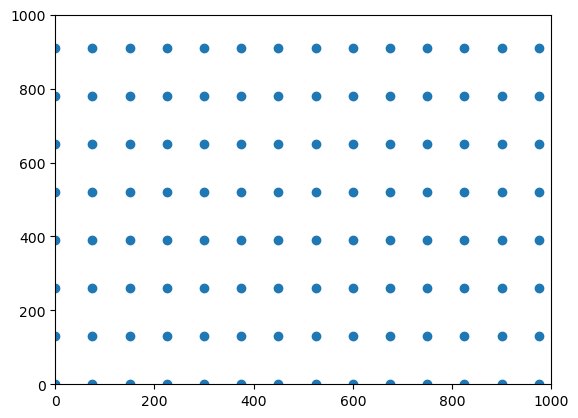

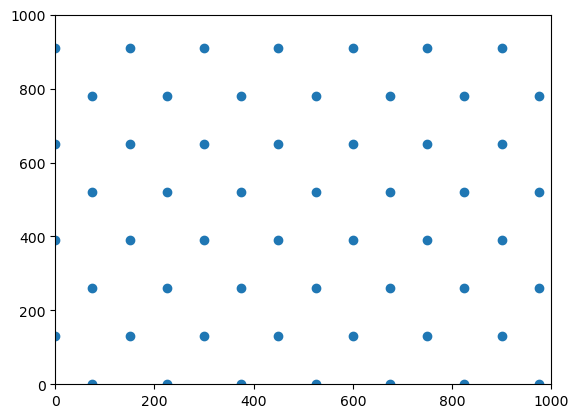

In [280]:
plt.scatter(np.asarray(complete_grid_list)[:,0],np.asarray(complete_grid_list)[:,1])
plt.xlim(0,1000)
plt.ylim(0,1000)

plt.show()

plt.scatter(np.asarray(detector_grid_list)[:,0],np.asarray(detector_grid_list)[:,1])
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()


## Funciones de busqueda de detector

In [281]:

def search_detector(x,y,detector_grid_list,tol):
    '''
    search_detector(x,y,detector_grid_array,tol) finds which detector does a particle hit (in case it hits a detector) 
    and returns it's position or np.Nan (if the particle does not hit a detector)
    
    the parameters are:
    x:                    the position x of the particle
    y:                    the position y of the particle
    detector_grid_list:   a list of tuples containing the detector positions
    tol:                  a tolerance for particle detection (radius of the detector)
    
    '''
    detector_grid_list=np.asarray(detector_grid_list)
    
    first=detector_grid_list[detector_grid_list[:,0]<x+80]
    second=first[first[:,0]>x-80]
    third=second[second[:,1]<y+130 ]
    possible_dets=third[third[:,1]>y-130]
    
    for det in possible_dets:
        if (np.sqrt((det[0]-x)**2 + (det[1]-y)**2)<=tol**2):
            return (det[0],det[1])
    return np.nan
    

In [282]:
def assign_to_detector(det_position,df,tol,pf_tol=(None,None)):
    '''
    given a detector position and a tolerance (radius), assign_to_detector(det_position,df,tol) filters the particles that fall
    inside that given detector and updates the dataframe of particles, assigning the
    detector position to the 'detector' column of those entries that fall inside the detector
    
    it also deletes the entries that are in the neighbourhood of the detector but do not fall inside the detector
    
    the parameters are:
    det_position:              a tuple that contains the position (x,y) of the detector
    df:                        the DataFrame of all entries
    tol:                       a tolerance for particle detection (radius of the detector)
    pf_tol=(pf_tolx,pf_toly):  [IGNORE] a tolerance for a preliminary filtering of particles in a rectangular neighbourhood of the detector 
                               (dimensions: 2*pf_tolx by 2*pf_toly) centered at the detector.
                               it is necesary that tol<=pf_tol(both components). large values will cause problems if the rectangular
                               neighbourhood is too big and overlaps with the bounds of other detectors 
    
    the function returns the updated DataFrame
                          
    '''
    if pf_tol==(None,None):
        pf_tol=(1.01*tol,1.01*tol)
    
    det_x,det_y=det_position
    pf_tolx,pf_toly=pf_tol
    possible_particles_index=df.index[(df['x']<=det_x+pf_tolx) & (df['x']>=det_x-pf_tolx) & (df['y']<=det_y+pf_toly) & (df['y']>=det_y-pf_toly)].tolist()
    for index in possible_particles_index:
        x,y=df.loc[index,'x'],df.loc[index,'y']
        if (x-det_x)**2 + (y-det_y)**2 <= tol**2:
            df.at[index,'detector']= det_position
        else:
            df.drop(index, inplace=True, axis=0)
    return df    

## Assignacion de detectores y filtro geometrico

In [283]:
i=0
filtered_data=all_data.copy()
start=default_timer()
for det_position in detector_grid_list:
    assign_to_detector(det_position,filtered_data,tol=10,pf_tol=(10.1,10.1))
    i+=1
    now=default_timer()
    imprimir_barra_de_carga(now-start,i,len(detector_grid_list), longitud=50)
filtered_data.dropna(inplace=True)
filtered_data=filtered_data.reset_index(drop=True)

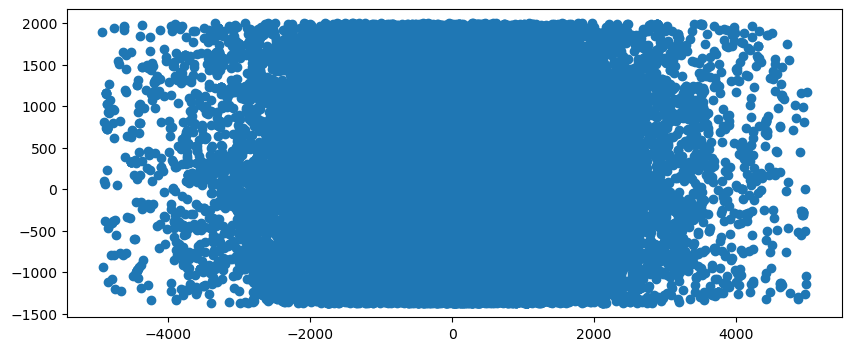

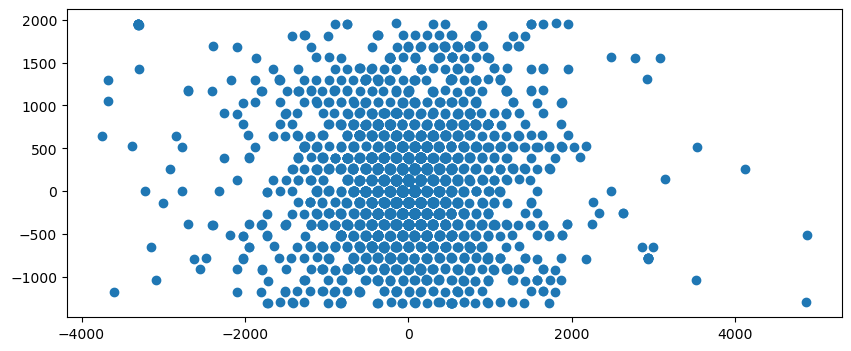

In [284]:
plt.figure(figsize=(10, 4))
plt.scatter(all_data['x'],all_data['y'])
#plt.xlim(0,1000)
#plt.ylim(0,1000)
plt.show()
plt.figure(figsize=(10, 4))
plt.scatter(filtered_data['x'],filtered_data['y'])
#plt.xlim(0,1000)
#plt.ylim(0,1000)
#plt.show()

## energia por detector

In [285]:
len(filtered_data['detector'].unique())

557

In [286]:
count=0
energies=[]

for det_position in complete_grid_list:
    det_data=filtered_data[filtered_data['detector']==det_position]
    deposited_energy=sum(det_data['ek'])
    energies.append(deposited_energy)
    


In [287]:
filtered_data[filtered_data['detector']==(150.0, -1428.94)]

,id,x,y,t,px,py,pz,ek,w,lev,detector


In [288]:
energies[600]
complete_grid_list[600]

(150.0, -779.42)

In [289]:
np.unique(np.asarray(complete_grid_list)[:,1])

array([-1299.04, -1169.13, -1039.23,  -909.33,  -779.42,  -649.52,
        -519.62,  -389.71,  -259.81,  -129.9 ,     0.  ,   129.9 ,
         259.81,   389.71,   519.62,   649.52,   779.42,   909.33,
        1039.23,  1169.13,  1299.04,  1428.94,  1558.85,  1688.75,
        1818.65,  1948.56])

In [290]:
y_dets=np.unique(np.asarray(complete_grid_list)[:,1])
x_dets=np.unique(np.asarray(complete_grid_list)[:,0])
len_x=len(x_dets)
len_y=len(y_dets)

det_matrix=np.zeros((len_y,len_x,3)) #det_matrix[i,j,:] (position_x,position_y,energy)

for i in range(len_y):
    y_pos=y_dets[-i-1]
    for j in range(len_x):
        x_pos=x_dets[j]
        det_matrix[i,j,0]=x_pos
        det_matrix[i,j,1]=y_pos
        det_matrix[i,j,2]=float(energies[complete_grid_list.index((x_pos,y_pos))])

## GRAFICO DE LOS DETECTORES QUE HAN SIDO ALCANZADOS

C:\Users\cg_h2\AppData\Local\Temp\ipykernel_2296\456499167.py:4: RuntimeWarning: invalid value encountered in floor_divide
  plt.imshow(det_matrix[:,:,2]//det_matrix[:,:,2],aspect=(10/4)) ##det_matrix[:,:,2]/det_matrix[:,:,2] to visualice which detectors have been hit #plt.xticks(ticksX,np.asarray(x_dets,dtype=np.int64)[ticksX])


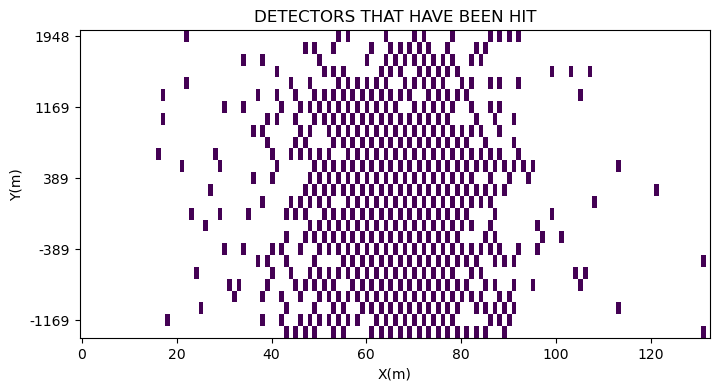

In [306]:
ticksX=[i*((len_x-1)//2)//3+ ((len_x-1)//2) for i in range(-3,4)]
ticksY=[i*((len_y-1)//4)+ ((len_y-1)//2) for i in range(-2,3)]
plt.figure(figsize=(10, 4))
plt.imshow(det_matrix[:,:,2]//det_matrix[:,:,2],aspect=(10/4)) ##det_matrix[:,:,2]/det_matrix[:,:,2] to visualice which detectors have been hit #plt.xticks(ticksX,np.asarray(x_dets,dtype=np.int64)[ticksX])
plt.yticks(ticksY,np.asarray(y_dets,dtype=np.int64)[(-1)*np.asarray(ticksY)-1])
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('DETECTORS THAT HAVE BEEN HIT')
plt.show()

## Grafico de energia por detector en el espacio

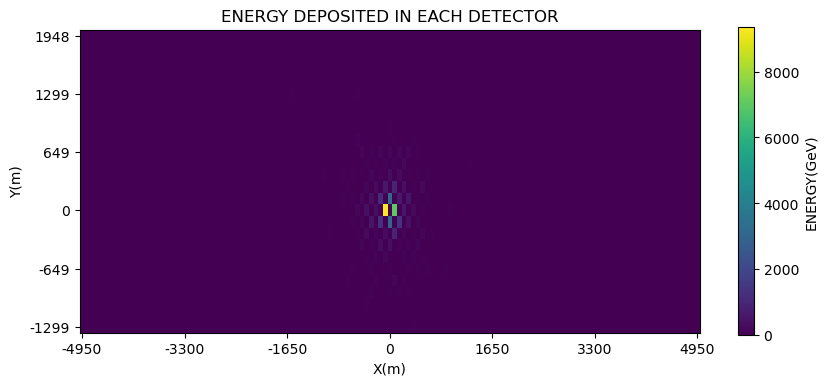

Total energy: 44.927  TeV


In [345]:
ticksX=[i*((len_x-1)//2)//3+ ((len_x-1)//2) for i in range(-3,4)]
ticksY=[i*((len_y-1)//4)+ ((len_y-1)//2) for i in range(-2,3)]
plt.figure(figsize=(10, 4))
plt.imshow(det_matrix[:,:,2],aspect=(10/4)) ##det_matrix[:,:,2]/det_matrix[:,:,2] to visualice which detectors have been hit 
plt.xticks(ticksX,np.asarray(x_dets,dtype=np.int64)[ticksX])
#plt.yticks(ticksY,np.asarray(y_dets,dtype=np.int64)[(-1)*np.asarray(ticksY)-1])
plt.yticks([0,5,10,15,20,25],np.asarray(y_dets[::-1][([0,5,10,15,20,25])],dtype=np.int64))

plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('ENERGY DEPOSITED IN EACH DETECTOR')
plt.colorbar(label='ENERGY(GeV)')
plt.show()
print('Total energy: %.3lf'%(np.sum(det_matrix[:,:,2])/1000),' TeV')

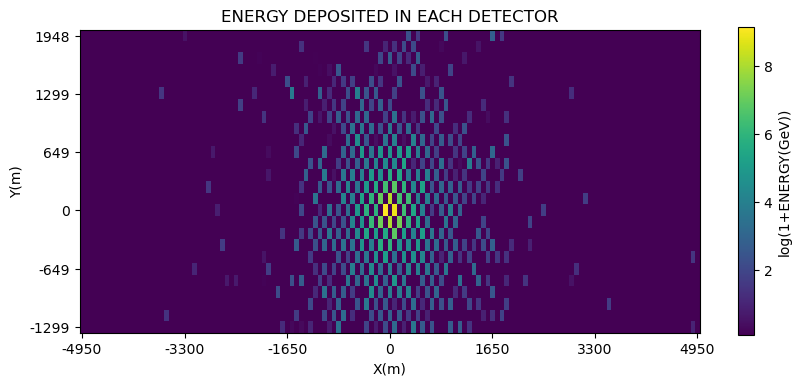

Total energy: 44.927  TeV


In [349]:
ticksX = [i * ((len_x - 1) // 2) // 3 + ((len_x - 1) // 2) for i in range(-3, 4)]

# Generate ticks for the y-axis
ticksY = [i * ((len_y - 1) // 4) + ((len_y - 1) // 2) for i in range(-2, 3)]

# Create a figure
plt.figure(figsize=(10, 4))

# Set a minimum value for the color scale
min_value = 0.1  # Adjust this value as needed

# Display the image (heatmap) with a logarithmic color scale
plt.imshow(np.log1p(det_matrix[:, :, 2]), aspect=(10/4), cmap='viridis', vmin=np.log1p(min_value))

# Set x-axis ticks
plt.xticks(ticksX, np.asarray(x_dets, dtype=np.int64)[ticksX])

# Set y-axis ticks
plt.yticks([0, 5, 10, 15, 20, 25], np.asarray(y_dets[::-1][[0, 5, 10, 15, 20, 25]], dtype=np.int64))

# Set labels and title
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('ENERGY DEPOSITED IN EACH DETECTOR')

# Add colorbar
plt.colorbar(label='log(1+ENERGY(GeV))')

# Show the plot
plt.show()

# Print the total energy
print('Total energy: %.3lf' % (np.sum(det_matrix[:, :, 2]) / 1000), ' TeV')

In [340]:
y_dets[::-1][([0,5,10,15,20,25])]

array([ 1948.56,  1299.04,   649.52,     0.  ,  -649.52, -1299.04])

In [336]:
len_y-np.asarray([0,5,10,15,20,25])

array([26, 21, 16, 11,  6,  1])

# Density Plot

In [260]:
i=0
density_df=all_data.copy()
start=default_timer()
for det_position in complete_grid_list:
    assign_to_detector(det_position,density_df,tol=10,pf_tol=(10.1,10.1))
    i+=1
    now=default_timer()
    imprimir_barra_de_carga(now-start,i,len(complete_grid_list), longitud=50)
density_df.dropna(inplace=True)
density_df=density_df.reset_index(drop=True)

KeyboardInterrupt: 

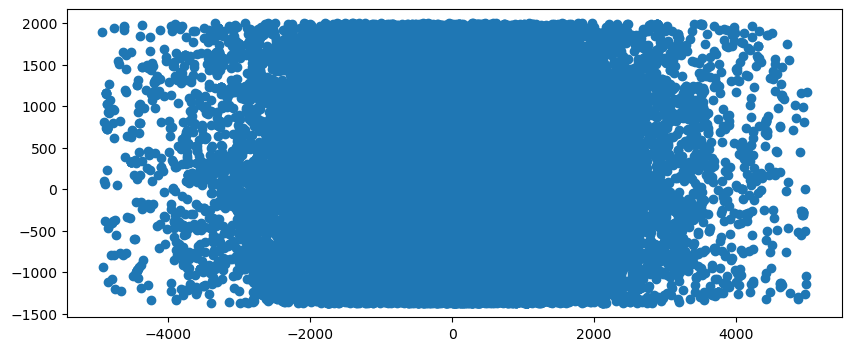

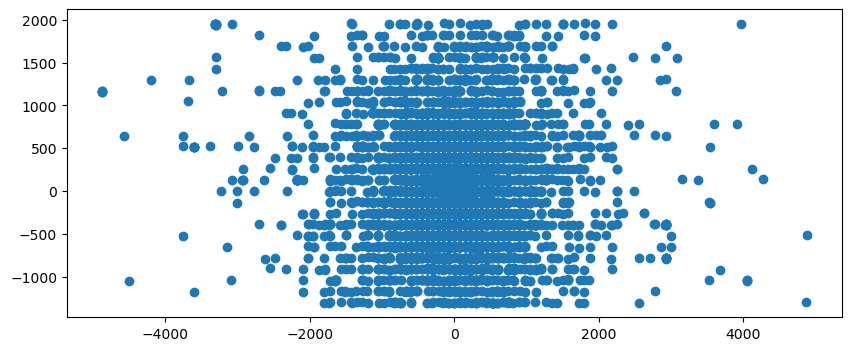

In [203]:
plt.figure(figsize=(10, 4))
plt.scatter(all_data['x'],all_data['y'])
#plt.xlim(0,1000)
#plt.ylim(0,1000)
plt.show()
plt.figure(figsize=(10, 4))
plt.scatter(density_df['x'],density_df['y'])
#plt.xlim(0,1000)
#plt.ylim(0,1000)
#plt.show()

In [204]:
count=0
particles=[]

for det_position in complete_grid_list:
    det_data=density_df[density_df['detector']==det_position]
    particle_count=len(det_data['ek'])
    particles.append(particle_count)
    


In [205]:
y_dets=np.unique(np.asarray(complete_grid_list)[:,1])
x_dets=np.unique(np.asarray(complete_grid_list)[:,0])
len_x=len(x_dets)
len_y=len(y_dets)

det_matrix=np.zeros((len_y,len_x,3)) #det_matrix[i,j,:] (position_x,position_y,energy)

for i in range(len_y):
    y_pos=y_dets[-i-1]
    for j in range(len_x):
        x_pos=x_dets[j]
        det_matrix[i,j,0]=x_pos
        det_matrix[i,j,1]=y_pos
        det_matrix[i,j,2]=float(particles[complete_grid_list.index((x_pos,y_pos))])

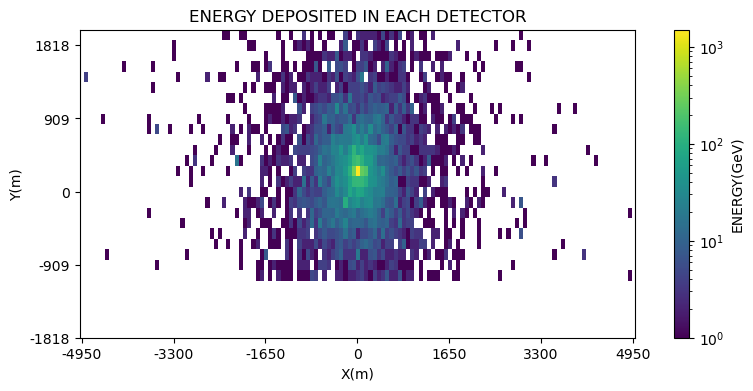

Total energy:  9850.0  GeV


In [218]:
ticksX=[i*((len_x-1)//2)//3+ ((len_x-1)//2) for i in range(-3,4)]
ticksY=[i*((len_y-1)//4)+ ((len_y-1)//2) for i in range(-2,3)]
plt.figure(figsize=(10, 4))
plt.imshow(det_matrix[:,:,2],aspect=(10/4),norm=cl.LogNorm()) ##det_matrix[:,:,2]/det_matrix[:,:,2] to visualice which detectors have been hit 
plt.xticks(ticksX,np.asarray(x_dets,dtype=np.int64)[ticksX])
plt.yticks(ticksY,np.asarray(y_dets,dtype=np.int64)[(-1)*np.asarray(ticksY)-1])
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('ENERGY DEPOSITED IN EACH DETECTOR')
plt.colorbar(label='ENERGY(GeV)')
plt.show()
print('Total energy: ',np.sum(det_matrix[:,:,2]),' GeV')